In [1]:
# %%capture
# !git clone https://github.com/quangster/marl-delivery.git
# %cd marl-delivery
# !pip install -r requirements.txt

## Evaluate QMIX_VDN_MAPPO

In [2]:
class QMIX_VDN_Args:
    def __init__(self, **config):
        # Environment params
        self.map_file = "map1.txt"
        self.n_robots = 2
        self.n_packages = 5
        self.max_time_steps = 100
        self.model_save_dir = ".//weights/"
    
        # Training parameters
        self.max_train_steps = int(1e6) * 5
        self.evaluate_freq = 5000
        self.evaluate_times = 32
        self.save_freq = 100000

        # Algorithm parameters
        self.algorithm = "QMIX"
        self.epsilon = 1.0
        self.epsilon_decay_steps = 50000
        self.epsilon_min = 0.05
        self.buffer_size = 5000
        self.batch_size = 32
        self.lr = 5e-4
        self.gamma = 0.99

        # Network architecture
        self.qmix_hidden_dim = 64
        self.hyper_hidden_dim = 128
        self.hyper_layers_num = 2
        self.rnn_hidden_dim = 128
        self.mlp_hidden_dim = 128

        # Feature flags
        self.use_rnn = False
        self.use_orthogonal_init = True
        self.use_grad_clip = True
        self.use_lr_decay = False
        self.use_RMS = False
        self.add_last_action = True
        self.add_agent_id = True
        self.use_double_q = True
        self.use_reward_norm = False
        self.use_hard_update = True
        self.target_update_freq = 200
        self.tau = 0.005

        for k, v in config.items():
            setattr(self, k, v)
        
        # Calculate epsilon decay
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.epsilon_decay_steps

In [3]:
class MAPPO_Args:
    def __init__(self, **config):
        # Environment parameters
        self.map_file = "map.txt"
        self.n_robots = 2
        self.n_packages = 5
        self.max_time_steps = 100
        self.model_save_dir = "./weights/"
        self.algorithm = "MAPPO"

        # Training parameters
        self.max_train_steps = int(1e6)
        self.evaluate_freq = 20000.0
        self.evaluate_times = 32
        self.save_freq = int(1e5)

        # Algorithm parameters
        self.batch_size = 32
        self.mini_batch_size = 8
        self.rnn_hidden_dim = 64
        self.mlp_hidden_dim = 64
        self.lr = 5e-4
        self.gamma = 0.99
        self.lamda = 0.95
        self.epsilon = 0.2
        self.K_epochs = 15
        self.entropy_coef = 0.01

        # Feature flags
        self.use_adv_norm = False
        self.use_reward_norm = False
        self.use_reward_scaling = False
        self.use_lr_decay = False
        self.use_grad_clip = False
        self.use_orthogonal_init = False
        self.set_adam_eps = False
        self.use_relu = False
        self.use_rnn = False
        self.add_agent_id = False
        self.use_agent_specific = False
        self.use_value_clip = False

        # Override with any custom config
        for k, v in config.items():
            setattr(self, k, v)

In [4]:
import wandb

def download_config_weights_wandb(run_path):
    api = wandb.Api()
    run =  api.run(run_path)
    print(run.config)
    # Download weights
    logged_artifacts = run.logged_artifacts()
    for artifact in logged_artifacts:
        if artifact.type == "model":
            artifact.download("./weights")
        print(artifact.name)
    return run.config

In [5]:
import numpy as np
from qmix_vdn import Runner_QMIX

def evaluate_qmix_vdn(runner: Runner_QMIX, times=32):
    runner.evaluate_and_record()
    rewards = []
    print(f"Evaluate {times} times on environment")
    print(f"- map_file: {runner.args.map_file}")
    print(f"- n_robots: {runner.args.n_robots}")
    print(f"- n_packages: {runner.args.n_packages}")
    print(f"- max_time_steps: {runner.args.max_time_steps}")

    for i in range(times):
        runner.env.reset()
        if runner.args.use_rnn:
            runner.agent_n.eval_Q_net.rnn_hidden = None
        last_onehot_a_n = np.zeros((runner.args.N, runner.args.action_dim))
        for episode_step in range(runner.args.episode_limit):
            obs_n, s = runner.env.get_state()
            avail_a_n = np.ones((runner.args.N, runner.args.action_dim))
            a_n = runner.agent_n.choose_action(obs_n, last_onehot_a_n, avail_a_n, 0)
            last_onehot_a_n = np.eye(runner.args.action_dim)[a_n]
            obs, r, done, _, info = runner.env.step(a_n)
        rewards.append(info["total_reward"])
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, marker='o')
    plt.title('Reward per Evaluation Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    avg_reward = np.mean(rewards)
    plt.axhline(avg_reward, color='red', linestyle='--', label=f'Average Reward: {avg_reward:.2f}')
    plt.legend()
    plt.show()

    return rewards

In [6]:
from mappo import Runner_MAPPO

def evaluate_mappo(runner: Runner_MAPPO, times=32):
    runner.evaluate_and_record()
    rewards = []
    print(f"Evaluate {times} times on environment")
    print(f"- map_file: {runner.args.map_file}")
    print(f"- n_robots: {runner.args.n_robots}")
    print(f"- n_packages: {runner.args.n_packages}")
    print(f"- max_time_steps: {runner.args.max_time_steps}")

    for i in range(times):
        runner.env.reset()
        if runner.args.use_reward_scaling:
            runner.reward_scaling.reset()
        if runner.args.use_rnn:  # If use RNN, before the beginning of each episode，reset the rnn_hidden
            runner.agent_n.actor.rnn_hidden = None
            runner.agent_n.critic.rnn_hidden = None
        for episode_step in range(runner.args.episode_limit):
            obs_n, s = runner.env.get_state()  # obs_n.shape=(N,obs_dim), s.shape=(state_dim,)
            avail_a_n = np.ones((runner.args.N, runner.args.action_dim))
            a_n, a_logprob_n = runner.agent_n.choose_action(obs_n, avail_a_n, evaluate=True)  # Get actions and the corresponding log probabilities of N agents
            # v_n = runner.agent_n.get_value(s, obs_n)  # Get the state values (V(s)) of N agents
            obs, r, done, _, info = runner.env.step(a_n)  # Take a step
        rewards.append(info["total_reward"])
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, marker='o')
    plt.title('Reward per Evaluation Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    avg_reward = np.mean(rewards)
    plt.axhline(avg_reward, color='red', linestyle='--', label=f'Average Reward: {avg_reward:.2f}')
    plt.legend()
    plt.show()

    return rewards

### map.txt 2 robots 5 packages 100 time_steps

VDN

In [7]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/tjgqeigg"
# conf = download_config_weights_wandb(run_path)

map_file=map.txt
max_time_steps=100
n_robots=2
n_packages=5
obs_dim=136
state_dim=196
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: VDN------
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/VDN-map-2r-5p-100t_step_58k_q_net.pth
- Mixer: weights/VDN-map-2r-5p-100t_step_58k_mixer_net.pth
Saved video: ./videos/VDN-map-2r-5p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 2
- n_packages: 5
- max_time_steps: 100


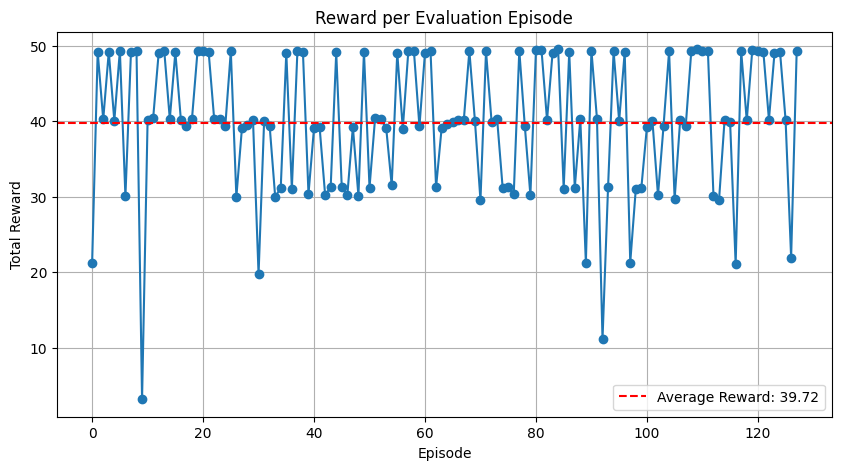

In [8]:
conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map.txt', 'n_robots': 2, 'algorithm': 'VDN', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 5, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/VDN-map-2r-5p-100t_step_58k_q_net.pth"
mixer_net_path = "weights/VDN-map-2r-5p-100t_step_58k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

QMIX

In [9]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/ulqia4cc"
# conf = download_config_weights_wandb(run_path)

map_file=map.txt
max_time_steps=100
n_robots=2
n_packages=5
obs_dim=136
state_dim=196
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=2
hyper_layers_num=2
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/QMIX-map-2r-5p-100t_step_55k_q_net.pth
- Mixer: weights/QMIX-map-2r-5p-100t_step_55k_mixer_net.pth
Saved video: ./videos/QMIX-map-2r-5p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 2
- n_packages: 5
- max_time_steps: 100


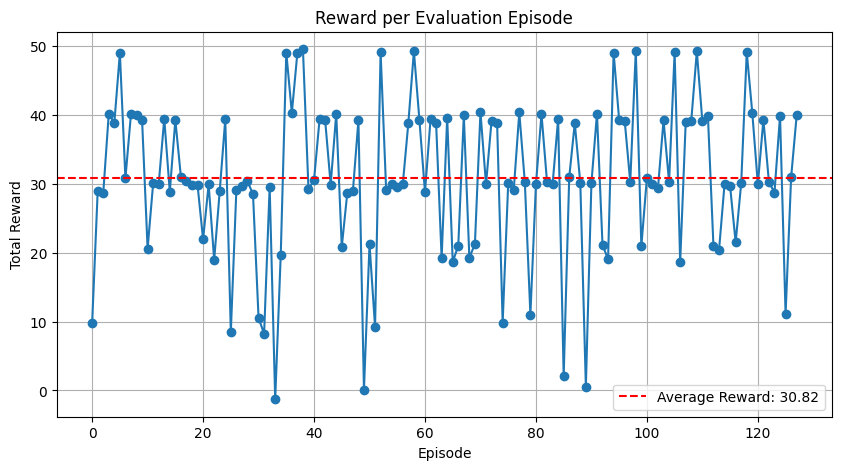

In [10]:
conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map.txt', 'n_robots': 2, 'algorithm': 'QMIX', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 5, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/QMIX-map-2r-5p-100t_step_55k_q_net.pth"
mixer_net_path = "weights/QMIX-map-2r-5p-100t_step_55k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

MAPPO

In [11]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/y3cakknu"
# conf = download_config_weights_wandb(run_path)

map_file=map.txt
max_time_steps=100
n_robots=2
n_packages=5
obs_dim=136
state_dim=196
action_dim=15
episode_limit=100
------use rnn------
------use_orthogonal_init------
------use_orthogonal_init------
------set adam eps------
------use reward norm------
Model loaded successfully:
- Actor network: weights/MAPPO-map-2r-5p-100t_actor_net.pth
- Critic network: weights/MAPPO-map-2r-5p-100t_critic_net.pth
Saved video: ./videos/MAPPO-map-2r-5p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 2
- n_packages: 5
- max_time_steps: 100


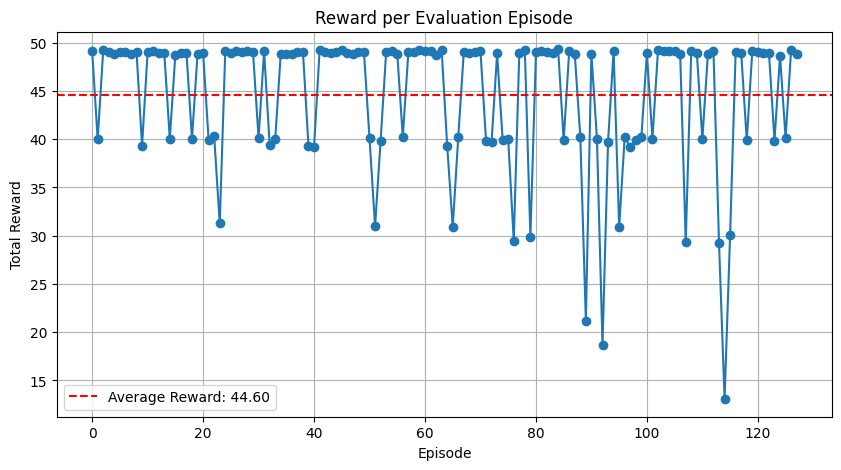

In [12]:
conf = {'lr': 0.0005, 'gamma': 0.99, 'lamda': 0.95, 'epsilon': 0.2, 'use_rnn': True, 'K_epochs': 15, 'map_file': 'map.txt', 'n_robots': 2, 'use_relu': True, 'algorithm': 'MAPPO', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 5, 'add_agent_id': False, 'entropy_coef': 0.01, 'set_adam_eps': True, 'use_adv_norm': True, 'use_lr_decay': True, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'use_value_clip': False, 'max_train_steps': 5000000, 'mini_batch_size': 8, 'use_reward_norm': True, 'use_agent_specific': False, 'use_reward_scaling': False, 'use_orthogonal_init': True}
actor_net_path = "weights/MAPPO-map-2r-5p-100t_actor_net.pth"
critic_net_path = "weights/MAPPO-map-2r-5p-100t_critic_net.pth"

args = MAPPO_Args(**conf)

runner = Runner_MAPPO(args, number=1, seed=59)
runner.load_weights(
    actor_net_path,
    critic_net_path
)

rewards = evaluate_mappo(runner, times=128)

### map.txt 5 robots 20 packages 100 time_steps

VDN

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/t0fzb6jg"
# conf = download_config_weights_wandb(run_path)

{'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map.txt', 'n_robots': 5, 'algorithm': 'VDN', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}


wandb:   1 of 1 files downloaded.  


VDN-map-5r-20p-100t_q_net:v0


wandb:   1 of 1 files downloaded.  


VDN-map-5r-20p-100t_mix_net:v0
run-t0fzb6jg-history:v0


map_file=map.txt
max_time_steps=100
n_robots=5
n_packages=20
obs_dim=145
state_dim=205
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: VDN------
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/VDN-map-5r-20p-100t_step_50k_q_net.pth
- Mixer: weights/VDN-map-5r-20p-100t_step_50k_mixer_net.pth
Saved video: ./videos/VDN-map-5r-20p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 5
- n_packages: 20
- max_time_steps: 100


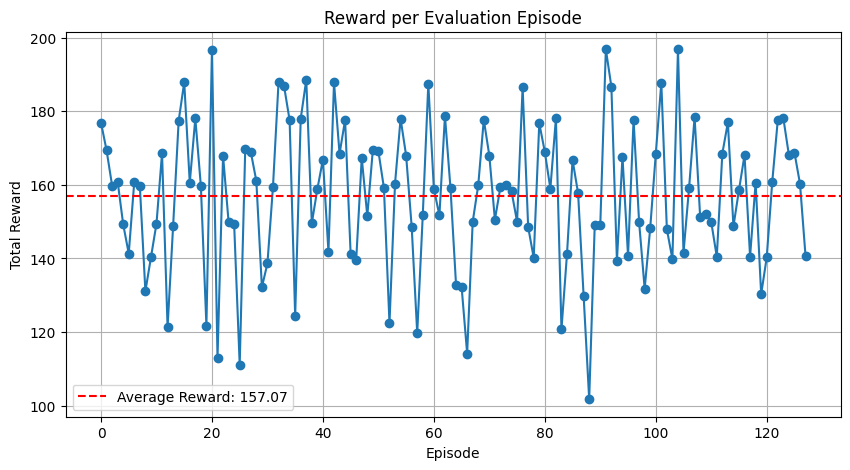

In [ ]:
conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map.txt', 'n_robots': 5, 'algorithm': 'VDN', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/VDN-map-5r-20p-100t_step_50k_q_net.pth"
mixer_net_path = "weights/VDN-map-5r-20p-100t_step_50k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

QMIX

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/mg7zct4v"
# conf = download_config_weights_wandb(run_path)

{'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map.txt', 'n_robots': 5, 'algorithm': 'QMIX', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}


wandb:   1 of 1 files downloaded.  


QMIX-map-5r-20p-100t_q_net:v1


wandb:   1 of 1 files downloaded.  


QMIX-map-5r-20p-100t_mix_net:v1
run-mg7zct4v-history:v0


map_file=map.txt
max_time_steps=100
n_robots=5
n_packages=20
obs_dim=145
state_dim=205
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=2
hyper_layers_num=2
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/QMIX-map-5r-20p-100t_step_50k_q_net.pth
- Mixer: weights/QMIX-map-5r-20p-100t_step_50k_mixer_net.pth
Saved video: ./videos/QMIX-map-5r-20p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 5
- n_packages: 20
- max_time_steps: 100


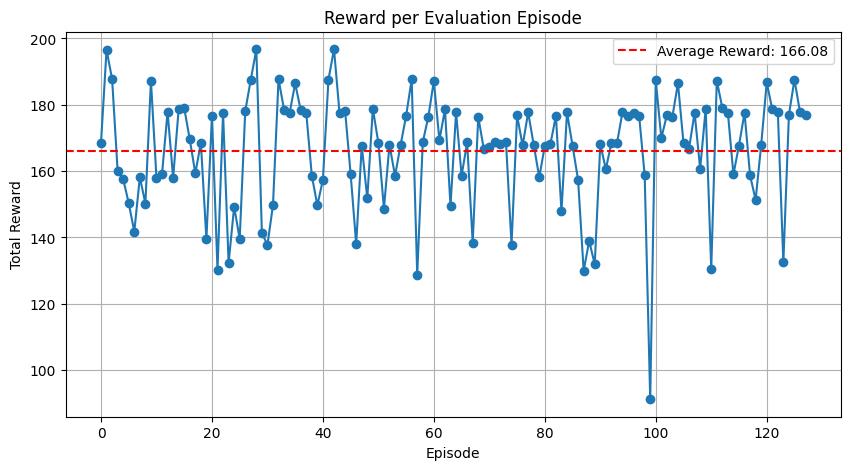

In [ ]:
conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map.txt', 'n_robots': 5, 'algorithm': 'QMIX', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/QMIX-map-5r-20p-100t_step_50k_q_net.pth"
mixer_net_path = "weights/QMIX-map-5r-20p-100t_step_50k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

MAPPO

map_file=map.txt
max_time_steps=100
n_robots=5
n_packages=20
obs_dim=145
state_dim=205
action_dim=15
episode_limit=100
------use_orthogonal_init------
------use_orthogonal_init------
------set adam eps------
------use reward norm------
Model loaded successfully:
- Actor network: weights/MAPPO-map-5r-20p-100t_actor_net.pth
- Critic network: weights/MAPPO-map-5r-20p-100t_critic_net.pth
Saved video: ./videos/MAPPO-map-5r-20p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 5
- n_packages: 20
- max_time_steps: 100


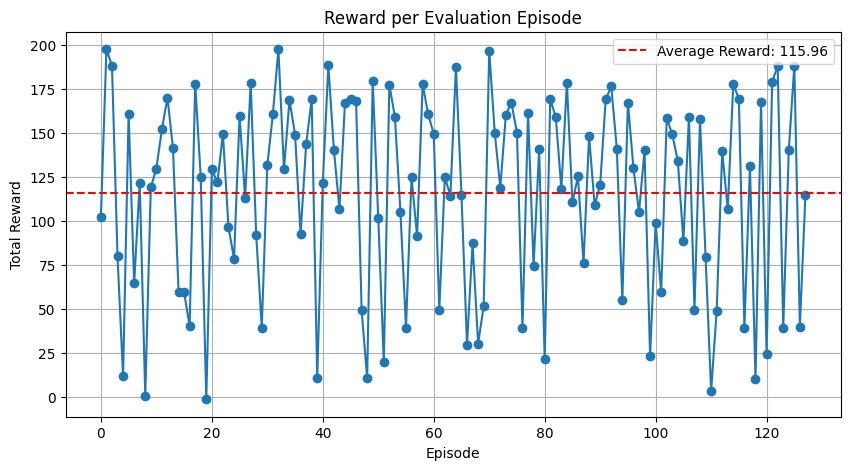

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/zg845eox"
# conf = download_config_weights_wandb(run_path)

conf = {'lr': 0.0005, 'gamma': 0.99, 'lamda': 0.95, 'epsilon': 0.2, 'use_rnn': False, 'K_epochs': 15, 'map_file': 'map.txt', 'n_robots': 5, 'use_relu': False, 'algorithm': 'MAPPO', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'add_agent_id': False, 'entropy_coef': 0.01, 'set_adam_eps': True, 'use_adv_norm': True, 'use_lr_decay': True, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'use_value_clip': True, 'max_train_steps': 5000000, 'mini_batch_size': 8, 'use_reward_norm': True, 'use_agent_specific': False, 'use_reward_scaling': False, 'use_orthogonal_init': True}
actor_net_path = "weights/MAPPO-map-5r-20p-100t_actor_net.pth"
critic_net_path = "weights/MAPPO-map-5r-20p-100t_critic_net.pth"

args = MAPPO_Args(**conf)

runner = Runner_MAPPO(args, number=1, seed=59)
runner.load_weights(
    actor_net_path,
    critic_net_path
)

rewards = evaluate_mappo(runner, times=128)

### map1.txt 2 robots 5 packages 100 time_steps

VDN

map_file=map1.txt
max_time_steps=100
n_robots=2
n_packages=5
obs_dim=187
state_dim=247
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: VDN------
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/VDN-map1-2r-5p-100t_step_50k_q_net.pth
- Mixer: weights/VDN-map1-2r-5p-100t_step_50k_mixer_net.pth
Saved video: ./videos/VDN-map1-2r-5p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map1.txt
- n_robots: 2
- n_packages: 5
- max_time_steps: 100


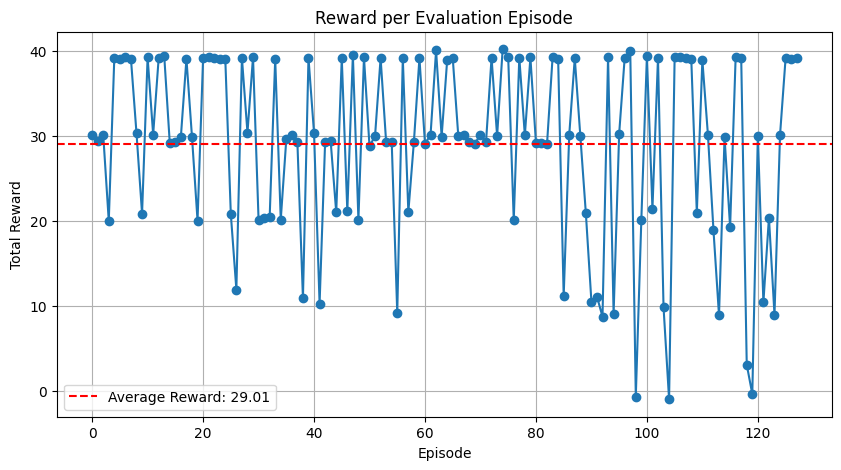

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/d4qz9leg"
# conf = download_config_weights_wandb(run_path)

conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map1.txt', 'n_robots': 2, 'algorithm': 'VDN', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 5, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/VDN-map1-2r-5p-100t_step_50k_q_net.pth"
mixer_net_path = "weights/VDN-map1-2r-5p-100t_step_50k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

QMIX

map_file=map1.txt
max_time_steps=100
n_robots=2
n_packages=5
obs_dim=187
state_dim=247
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use MLP------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=2
hyper_layers_num=2
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/QMIX-map1-2r-5p-100t_step_56k_q_net.pth
- Mixer: weights/QMIX-map1-2r-5p-100t_step_56k_mixer_net.pth
Saved video: ./videos/QMIX-map1-2r-5p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map1.txt
- n_robots: 2
- n_packages: 5
- max_time_steps: 100


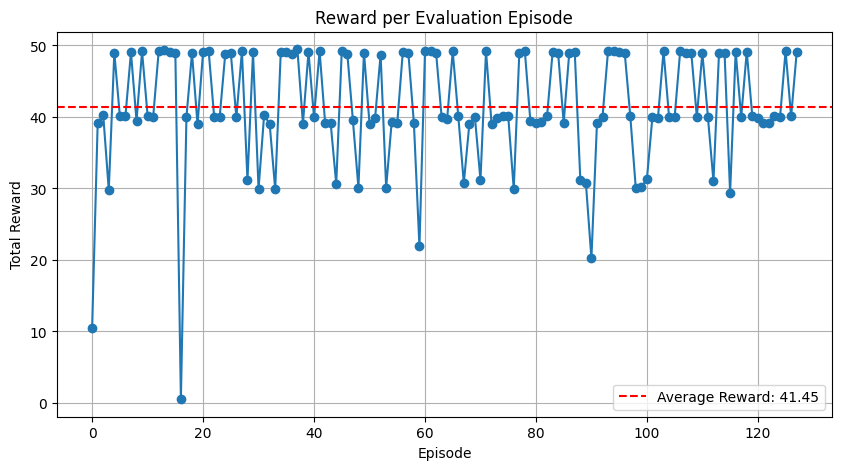

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/foz3x9jg"
# conf = download_config_weights_wandb(run_path)

conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': False, 'map_file': 'map1.txt', 'n_robots': 2, 'algorithm': 'QMIX', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 5, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 128, 'model_save_dir': './weights/', 'rnn_hidden_dim': 128, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 64, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 128, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/QMIX-map1-2r-5p-100t_step_56k_q_net.pth"
mixer_net_path = "weights/QMIX-map1-2r-5p-100t_step_56k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

MAPPO

map_file=map.txt
max_time_steps=100
n_robots=5
n_packages=20
obs_dim=145
state_dim=205
action_dim=15
episode_limit=100
------use_orthogonal_init------
------use_orthogonal_init------
------set adam eps------
------use reward norm------
Model loaded successfully:
- Actor network: weights/MAPPO-map-5r-20p-100t_actor_net.pth
- Critic network: weights/MAPPO-map-5r-20p-100t_critic_net.pth
Saved video: ./videos/MAPPO-map-5r-20p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 5
- n_packages: 20
- max_time_steps: 100


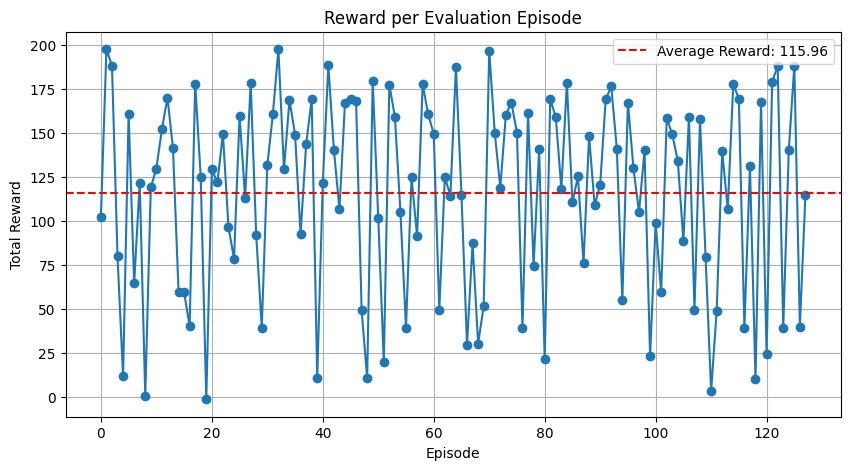

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/zg845eox"
# conf = download_config_weights_wandb(run_path)

conf = {'lr': 0.0005, 'gamma': 0.99, 'lamda': 0.95, 'epsilon': 0.2, 'use_rnn': False, 'K_epochs': 15, 'map_file': 'map.txt', 'n_robots': 5, 'use_relu': False, 'algorithm': 'MAPPO', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'add_agent_id': False, 'entropy_coef': 0.01, 'set_adam_eps': True, 'use_adv_norm': True, 'use_lr_decay': True, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'use_value_clip': True, 'max_train_steps': 5000000, 'mini_batch_size': 8, 'use_reward_norm': True, 'use_agent_specific': False, 'use_reward_scaling': False, 'use_orthogonal_init': True}
actor_net_path = "weights/MAPPO-map-5r-20p-100t_actor_net.pth"
critic_net_path = "weights/MAPPO-map-5r-20p-100t_critic_net.pth"

args = MAPPO_Args(**conf)

runner = Runner_MAPPO(args, number=1, seed=59)
runner.load_weights(
    actor_net_path,
    critic_net_path
)

rewards = evaluate_mappo(runner, times=128)

### map1.txt 5 robots 20 packages 100 time_steps

VDN

map_file=map1.txt
max_time_steps=100
n_robots=5
n_packages=20
obs_dim=196
state_dim=256
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: VDN------
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/VDN-map1-5r-20p-100t_step_49k_q_net.pth
- Mixer: weights/VDN-map1-5r-20p-100t_step_49k_mixer_net.pth
Saved video: ./videos/VDN-map1-5r-20p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map1.txt
- n_robots: 5
- n_packages: 20
- max_time_steps: 100


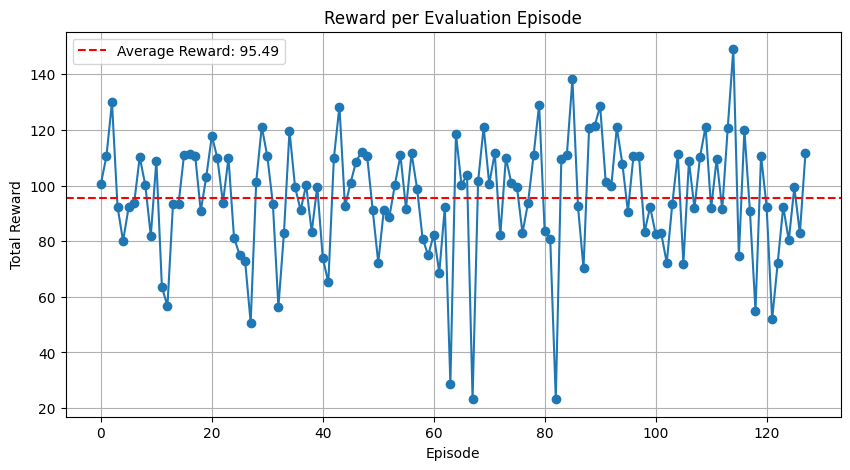

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/i24hne9r"
# conf = download_config_weights_wandb(run_path)

conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': True, 'map_file': 'map1.txt', 'n_robots': 5, 'algorithm': 'VDN', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/VDN-map1-5r-20p-100t_step_49k_q_net.pth"
mixer_net_path = "weights/VDN-map1-5r-20p-100t_step_49k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

QMIX

map_file=map1.txt
max_time_steps=100
n_robots=5
n_packages=20
obs_dim=196
state_dim=256
action_dim=15
episode_limit=100
------add last action------
------add agent id------
------use MLP------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=2
hyper_layers_num=2
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/QMIX-map1-5r-20p-100t_step_49k_q_net.pth
- Mixer: weights/QMIX-map1-5r-20p-100t_step_49k_mixer_net.pth
Saved video: ./videos/QMIX-map1-5r-20p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map1.txt
- n_robots: 5
- n_packages: 20
- max_time_steps: 100


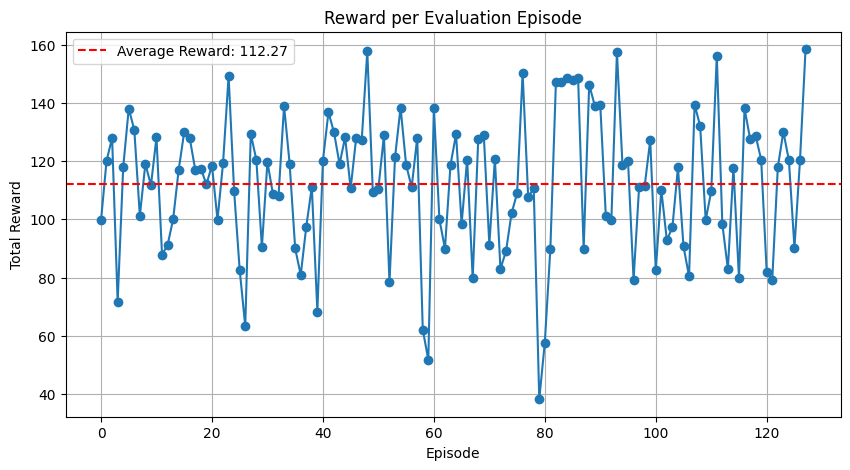

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/utxdlhsl"
# conf = download_config_weights_wandb(run_path)

conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': False, 'map_file': 'map1.txt', 'n_robots': 5, 'algorithm': 'QMIX', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 128, 'model_save_dir': './weights/', 'rnn_hidden_dim': 128, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 64, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 128, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/QMIX-map1-5r-20p-100t_step_49k_q_net.pth"
mixer_net_path = "weights/QMIX-map1-5r-20p-100t_step_49k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)

MAPPO

map_file=map1.txt
max_time_steps=100
n_robots=5
n_packages=20
obs_dim=196
state_dim=256
action_dim=15
episode_limit=100
------use_orthogonal_init------
------use_orthogonal_init------
------set adam eps------
------use reward norm------
Model loaded successfully:
- Actor network: weights/MAPPO-map1-5r-20p-100t_actor_net.pth
- Critic network: weights/MAPPO-map1-5r-20p-100t_critic_net.pth
Saved video: ./videos/MAPPO-map1-5r-20p-100t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map1.txt
- n_robots: 5
- n_packages: 20
- max_time_steps: 100


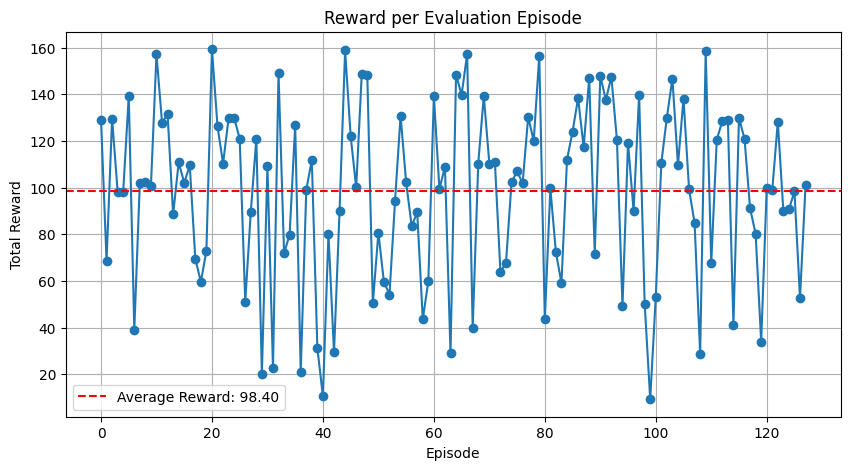

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/gjrzysoc"
# conf = download_config_weights_wandb(run_path)

conf = {'lr': 0.0005, 'gamma': 0.99, 'lamda': 0.95, 'epsilon': 0.2, 'use_rnn': False, 'K_epochs': 15, 'map_file': 'map1.txt', 'n_robots': 5, 'use_relu': False, 'algorithm': 'MAPPO', 'save_freq': 100000, 'batch_size': 32, 'n_packages': 20, 'add_agent_id': False, 'entropy_coef': 0.01, 'set_adam_eps': True, 'use_adv_norm': True, 'use_lr_decay': True, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 100, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'use_value_clip': True, 'max_train_steps': 5000000, 'mini_batch_size': 8, 'use_reward_norm': True, 'use_agent_specific': False, 'use_reward_scaling': False, 'use_orthogonal_init': True}
actor_net_path = "weights/MAPPO-map1-5r-20p-100t_actor_net.pth"
critic_net_path = "weights/MAPPO-map1-5r-20p-100t_critic_net.pth"

args = MAPPO_Args(**conf)

runner = Runner_MAPPO(args, number=1, seed=59)
runner.load_weights(
    actor_net_path,
    critic_net_path
)

rewards = evaluate_mappo(runner, times=128)

### QMIX map.txt 2 robots 20 packages 200 max_time_steps

In [ ]:
# run_path = "quangster-vietnam-national-university-hanoi/RL-MAPD/13pzz55n"
# conf = download_config_weights_wandb(run_path)

map_file=map.txt
max_time_steps=200
n_robots=2
n_packages=20
obs_dim=136
state_dim=196
action_dim=15
episode_limit=200
------add last action------
------add agent id------
------use MLP------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=2
hyper_layers_num=2
------optimizer: Adam------
------use reward norm------
Model loaded successfully:
- Q Network: weights/QMIX-map-2r-20p-200t_step_24k_q_net.pth
- Mixer: weights/QMIX-map-2r-20p-200t_step_24k_mixer_net.pth
Saved video: ./videos/QMIX-map-2r-20p-200t-episode-0.mp4
Evaluate 128 times on environment
- map_file: map.txt
- n_robots: 2
- n_packages: 20
- max_time_steps: 200


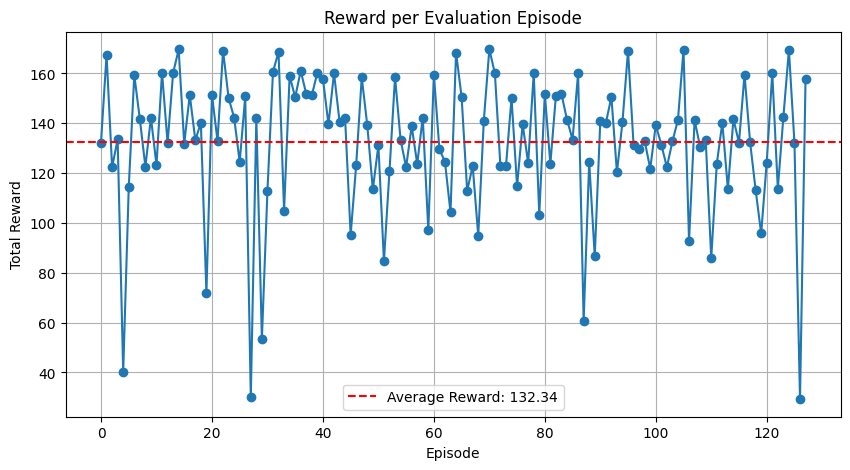

In [ ]:
conf = {'lr': 0.0005, 'tau': 0.005, 'gamma': 0.99, 'epsilon': 1, 'use_RMS': False, 'use_rnn': False, 'map_file': 'map.txt', 'n_robots': 2, 'algorithm': 'QMIX', 'save_freq': 100000, 'batch_size': 16, 'n_packages': 20, 'buffer_size': 5000, 'epsilon_min': 0.05, 'add_agent_id': True, 'use_double_q': True, 'use_lr_decay': False, 'epsilon_decay': 1.9e-05, 'evaluate_freq': 20000, 'use_grad_clip': True, 'evaluate_times': 32, 'max_time_steps': 200, 'mlp_hidden_dim': 64, 'model_save_dir': './weights/', 'rnn_hidden_dim': 64, 'add_last_action': True, 'max_train_steps': 5000000, 'qmix_hidden_dim': 32, 'use_hard_update': True, 'use_reward_norm': True, 'hyper_hidden_dim': 64, 'hyper_layers_num': 2, 'target_update_freq': 200, 'epsilon_decay_steps': 50000, 'use_orthogonal_init': True}
q_net_path = "weights/QMIX-map-2r-20p-200t_step_24k_q_net.pth"
mixer_net_path = "weights/QMIX-map-2r-20p-200t_step_24k_mixer_net.pth"

args = QMIX_VDN_Args(**conf)

runner = Runner_QMIX(args, number=1, seed=59)
runner.load_weights(
    q_net_path,
    mixer_net_path
)

rewards = evaluate_qmix_vdn(runner, times=128)